In [1]:
from fastai.vision.all import *
from fastaudio.all import *
from fastai.text.all import *

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [2]:
import editdistance
from fastai.callback.wandb import *

In [3]:
path = Path('../')

In [4]:
import romkan

In [5]:
table = {k:g for (k,g) in zip(["か゚","く゚","け゚","き゚",'こ゚', 'カ゚','ク゚','ケ゚','キ゚','コ゚'], 'がぐげぎごがぐげぎご')}

In [6]:
def convert_to_voiced(kana):
    for key,value in table.items():
        kana = kana.replace(key,value)
    return kana

In [7]:
convert_to_voiced('か゚')

'が'

In [96]:
labels = pd.read_csv('../training.csv', index_col=0)

In [97]:
labels.kana = labels.kana.map(convert_to_voiced)

In [98]:
labels.kana = labels.kana.map(romkan.to_hepburn)

In [99]:
labels.kana = labels.kana.map(romkan.to_katakana)

In [100]:
labels.kana = labels.kana.map(romkan.to_hepburn)

In [101]:
words = L(labels.kana.values.tolist())

In [103]:
whole = ''.join([word for word in words])

In [104]:
whole[:100]

'aruomounadowatakushimirukuruikuyukujibundo-ho-dekirukangaerukangaeruiimotsuwakaruderuokonauyaruyakuw'

In [105]:
vocab = L('',*list(whole))

In [106]:
vocab = vocab.unique()

In [18]:
vocab

(#27) ['','a','r','u','o','m','n','d','w','t'...]

In [107]:
letter2idx = {letter:idx for (idx,letter) in enumerate(vocab)}

In [20]:
letter2idx

{'': 0,
 'a': 1,
 'r': 2,
 'u': 3,
 'o': 4,
 'm': 5,
 'n': 6,
 'd': 7,
 'w': 8,
 't': 9,
 'k': 10,
 's': 11,
 'h': 12,
 'i': 13,
 'y': 14,
 'j': 15,
 'b': 16,
 '-': 17,
 'e': 18,
 'g': 19,
 'p': 20,
 'z': 21,
 'c': 22,
 'f': 23,
 "'": 24,
 'x': 25,
 ' ': 26}

In [108]:
labels = labels[labels.path != 'pitch_accent/OjadMedia/見上げさせる-1567_8_2_male.mp3']

In [110]:
splits = ColSplitter()(labels)
aud2spec = AudioToSpec.from_cfg(AudioConfig.Voice(f_min=0))

In [111]:
x_tfms = [lambda x: x[0], lambda x1: path/x1, AudioTensor.create,
          Resample(16_000), RemoveSilence(), ResizeSignal(2000)]
y_tfms = [lambda y: y["kana"], lambda y1: TensorText([letter2idx[i] for i in y1])]
dsets = Datasets(labels, [x_tfms, y_tfms], splits = splits)
dsets

(#160762) [(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([1, 2, 3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([4, 5, 4, 3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([6, 1, 7, 4])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 8,  1,  9,  1, 10,  3, 11, 12, 13])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 5, 13,  2,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([10,  3,  2,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([13, 10,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([14,  3, 10,  3])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([15, 13, 16,  3,  6])),(AudioTensor([[0., 0., 0.,  ..., 0., 0., 0.]]), TensorText([ 7,  4, 17]))...]

In [24]:
class SqueezeSpec(Transform):
    def encodes(self, x:AudioSpectrogram): return x.squeeze()#.cuda()

In [112]:
dls = dsets.dataloaders(before_batch = Pad_Chunk(0), after_batch=[aud2spec, SqueezeSpec()])
b = dls.one_batch()

In [26]:

class oldJasperSubblock(Module):
    r"A basic building sub-block of Jasper"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Conv1d(in_channels, out_channels, kernel, stride, (kernel-1)//2, **kwargs)
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
    
class JasperSubblock(Module):
    r"A basic building sub-block of Jasper with QuartzNet separable convolutions"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Sequential(nn.Conv1d(in_channels, in_channels, kernel, stride, (kernel-1)//2, groups=in_channels, **kwargs),
                                 nn.Conv1d(in_channels, out_channels, 1, 1))
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
class JasperBlock(Module):
    
    def __init__(self, in_channels, out_channels, kernel, num_subblocks=3, drop = 0.2):
        self.subblocks = nn.Sequential(*[JasperSubblock(in_channels, out_channels, kernel, 1, drop = 0.2)] \
        + [JasperSubblock(out_channels, out_channels, kernel, 1, drop = 0.2) for i in range(num_subblocks-2)])
        self.res_subblock = JasperSubblock(out_channels, out_channels, kernel, 1, drop = 0.2)
        self.res_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.res_norm = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x, res = self.subblocks(x), self.res_conv(x)
        x = self.res_subblock(x, self.res_norm(x))
        return x
    
class Jasper(Module):
    
    def __init__(self, n_mels, n_vocab, num_blocks_factor=1, num_subblocks = 3):
        KERNELS = [11, 13, 17, 21, 25]
        OUTS = [256, 384, 512, 640, 768, 256]
        DROPS = [0.2]*3 + [0.3]*2
        
        self.model = nn.Sequential(*[oldJasperSubblock(n_mels, 256, 11, 2)] \
        + [JasperBlock(OUTS[i-1], OUTS[i], KERNELS[i], num_subblocks, DROPS[i])
           for i in range(5) for _ in range(num_blocks_factor)] \
        + [oldJasperSubblock(OUTS[-2], 896, 29, 1, 0.4, dilation=2)],
          oldJasperSubblock(896, 1024, 1, 1, 0.4), nn.Conv1d(1024, n_vocab, 1), nn.LogSoftmax(1)
        )
        
    def forward(self, x):
        return self.model(x)

In [113]:
model = Jasper(b[0].shape[1], len(vocab)).cuda()

In [28]:
b[0].shape

torch.Size([64, 128, 251])

In [29]:
x,y = b

In [40]:
y.shape

torch.Size([64, 15])

In [41]:
out = model(x)
out.shape

torch.Size([64, 27, 98])

In [42]:
out[0,:,1]

AudioSpectrogram([-3.1368, -3.0432, -3.3284, -2.8967, -3.6796, -3.4793, -3.5128, -3.2683,
        -3.2523, -3.3570, -3.2364, -3.4322, -3.3831, -3.6307, -3.7863, -3.4435,
        -3.0615, -2.9223, -3.0556, -3.4710, -3.5061, -3.2821, -3.2456, -3.5706,
        -3.5964, -3.2415, -2.9244], device='cuda:0', grad_fn=<AliasBackward>)

In [43]:
out_rear =  torch.einsum("ijk->kij",out).cpu()
out_l = torch.full(fill_value = out_rear.shape[0], size = (out_rear.shape[1],) ).cpu()
y_l = torch.full(fill_value = y.shape[1], size = (y.shape[0],)).cpu()

In [44]:
out_rear.shape

torch.Size([98, 64, 27])

In [45]:
loss = nn.CTCLoss()(Tensor(out_rear), y, out_l, y_l)
loss

TensorText(16.4790, grad_fn=<AliasBackward>)

In [46]:
loss.backward()

In [132]:
CTC = nn.CTCLoss()
def ctc_loss_no_lens(preds, targs):
    preds = Tensor(torch.einsum("ijk->kij",preds).cpu())
    preds_l = torch.full(fill_value = preds.shape[0], size = (preds.shape[1],) )#.cpu()
    # targs_l = torch.full(fill_value = targs.shape[1], size = (targs.shape[0],))#.cpu()
    targs_l = targs.argmin(1)
    targs_l = torch.where(targs[:,-1]==0, targs.argmin(1), targs.shape[1])-1
    return CTC(preds, targs, preds_l, targs_l)

In [48]:
ctc_loss_no_lens(out, y)

TensorText(16.4790, grad_fn=<AliasBackward>)

In [49]:
out.shape

torch.Size([64, 27, 98])

In [50]:
out.argmax(1).shape

torch.Size([64, 98])

In [31]:
def unpad(text):
    return Pad_Chunk(0).decode(text)

def ctc_decode(pred, empid = 0):
    pred = pred.argmax(0)
    dec = [empid]
    for i in range(len(pred)):
        cur = int(pred[i])
        if cur != dec[-1]: dec.append(cur)
    return [i for i in dec if i!=0]

def ids_to_str(ids):
    return ''.join([vocab[i] for i in ids])

In [32]:
def CER(inp, targ):
    bs = inp.shape[0]
    cer = 0
    for i,t in zip(inp,targ):
        i = ids_to_str(ctc_decode(i))
        t = ids_to_str(unpad(t))
        cer += editdistance.eval(i,t)/len(t)
    return cer / bs * 100

In [33]:
def ctc_accuracy(inp, targ):
    bs = inp.shape[0]
    cer = 0
    for i,t in zip(inp,targ):
        i = ids_to_str(ctc_decode(i))
        t = ids_to_str(unpad(t))
        cer += i==t
    return cer / bs

In [54]:
out.shape

torch.Size([64, 27, 98])

In [55]:
CER(out,y)

939.9147553835054

In [56]:
ctc_accuracy(out,y)

0.0

In [42]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/.conda/envs/default/lib/python3.9/site-packages/fastai/metrics.py
Type:      function


In [57]:
import wandb

In [58]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mizoru (use `wandb login --relogin` to force relogin)


True

In [70]:
wandb.init()

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [133]:
learn = Learner(dls, model, loss_func=ctc_loss_no_lens, metrics = [CER, ctc_accuracy])
               # cbs=[WandbCallback(), SaveModelCallback()])

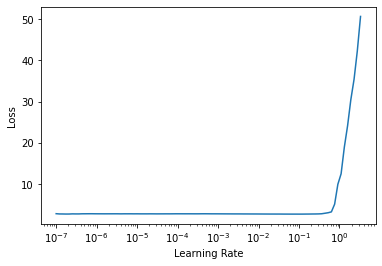

In [134]:
learn.lr_find(num_it = 100, stop_div=False, suggest_funcs=None)

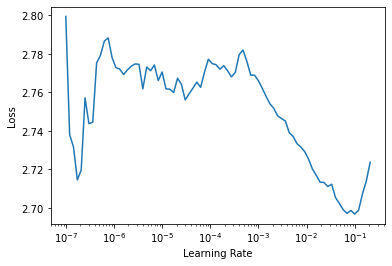

In [137]:
learn.recorder.plot_lr_find(20)

In [141]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [256, 128, 11], but got 2-dimensional input of size [128, 251] instead

In [78]:
wandb.finish()

AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

In [171]:
learn.save('QuartzNet')

Path('models/Jasper.pth')

In [142]:
with torch.no_grad():
    pred = learn.model(x)

In [121]:
pred[0].shape

torch.Size([27, 98])

In [67]:
predd = pred

In [78]:
predd[:,0] = -10

In [143]:
[''.join([vocab[i] for i in pred[j].argmax(0)]) for j in range(64)]

['kas',
 'akaakatt',
 'akash',
 'akaaakikaka',
 'asura',
 'shikat',
 'akaass',
 'akaasas',
 'akasshiyoo',
 'kanka',
 'akakarararer',
 'kanka',
 'akakakakanak',
 'kakaka',
 'sakaka',
 'saikashin',
 'akasshit',
 'akasshinakatttt',
 'akakik',
 'ake',
 'akaasss',
 'shika',
 'shkakakar',
 'akaka',
 'akaike',
 'shikussss',
 'ake',
 'akasshimas',
 'akika',
 'arararer',
 'akakakana',
 'shikek',
 'asukok',
 'akaakakarer',
 'arar',
 'shisuka',
 'kasuk',
 'akakakat',
 'akakaka',
 'akakak',
 'aka',
 'asuk',
 'asassurer',
 'shkakakass',
 'sakassaser',
 'shisuish',
 'shoshoshk',
 'akasshinakat',
 'akashinakattttt',
 'akakak',
 'akararr',
 'akakar',
 'kanka',
 'akaakakamamas',
 'akaak',
 'kanka',
 'shikaka',
 'akakak',
 'as',
 'akaasarer',
 'ake',
 'aka',
 'kakak',
 'shkakasssh']

In [39]:
def unpad(text):
    return Pad_Chunk(0).decode(text)

def ctc_decode(pred, empid = 0):
    pred = pred.argmax(0)
    dec = [empid]
    for i in range(len(pred)):
        cur = int(pred[i])
        if cur != dec[-1]: dec.append(cur)
    return [i for i in dec if i!=0]

def ids_to_str(ids):
    return ''.join([vocab[i] for i in ids])

In [40]:
[ids_to_str(unpad(y)) for y in b[1]]

['kanchi',
 'tegarujanai',
 'daiichi',
 'reigitadashikereba',
 'kusuberu',
 'shiruku',
 'kappatsu',
 'nejiremasu',
 'kousoshiyou',
 'migimae',
 'torikakaraseru',
 'hairan',
 'kokusaitekinaraba',
 'haininzai',
 'shinkabuochi',
 'shijishiro',
 'dansuishite',
 'kaigyoushinakatta',
 'dokukinoko',
 'tsukebumi',
 'torikese',
 'saikoku',
 'kikihoreru',
 'kaettekoi',
 'ijiwaruni',
 'shoukaisuru',
 'bibun',
 'nukashimasu',
 'kessakude',
 'nebaraseru',
 'fureaeba',
 'shinogi',
 'wakikyo-gen',
 'hibikiwataru',
 'manero',
 'shimireba',
 'genseki',
 'nadakakute',
 'seimitsukensa',
 'yamadome',
 'ka-to',
 'kashoku',
 'shousansureba',
 'tsumimasu',
 'enshutsusaseru',
 'shibo-sha',
 'mo-so-chiku',
 'nozomashikunai',
 'yuraishinakatta',
 'akeppiroge',
 'tsukerareru',
 'nawabari',
 'keiden',
 'kokoroduyoidesu',
 'samukute',
 'maikomu',
 'shirokuban',
 'heatonikku',
 'muki',
 'saisensareru',
 'mongon',
 'naosu',
 'hongoku',
 'sumigokochi']

In [41]:
ctc_decode(pred[0])

[]

In [84]:
preds,targs = learn.get_preds()

In [ ]:
[ids_to_str(ctc_decode(preds[i])) for i in range(64,128)]

In [ ]:
print('prediction', 'target', sep='\t')
print()
for i in range(1000,1100):
    print(*[ids_to_str(i) for i in (ctc_decode(preds[i]), unpad(targs[i]))], sep='\t\t')

In [86]:
preds[0, :, 3]

AudioSpectrogram([-0.9940, -3.0548, -3.4349, -3.0396, -3.3838, -3.4011, -3.5963, -4.0333,
        -5.6006, -3.0469, -2.9385, -2.9775, -3.1846, -2.8040, -3.7666, -4.9258,
        -4.8998, -3.6197, -3.4029, -4.6347, -5.6210, -5.1322, -4.9652, -5.8269,
        -5.7516, -6.3390, -6.6762])

In [268]:
Jasper(128, 27).cuda()(x)

Error in callback <function _WandbInit._resume_backend at 0x7f620c9edf70> (for pre_run_cell):


Exception: The wandb backend process has shutdown

AudioSpectrogram([[[0.0388, 0.0426, 0.0536,  ..., 0.0410, 0.0411, 0.0697],
         [0.0289, 0.0319, 0.0428,  ..., 0.0407, 0.0467, 0.0414],
         [0.0422, 0.0295, 0.0455,  ..., 0.0390, 0.0377, 0.0361],
         ...,
         [0.0510, 0.0505, 0.0312,  ..., 0.0570, 0.0590, 0.0735],
         [0.0339, 0.0365, 0.0271,  ..., 0.0374, 0.0543, 0.0359],
         [0.0413, 0.0429, 0.0271,  ..., 0.0395, 0.0348, 0.0300]],

        [[0.0486, 0.0286, 0.0308,  ..., 0.0315, 0.0478, 0.0269],
         [0.0568, 0.0362, 0.0392,  ..., 0.0333, 0.0468, 0.0203],
         [0.0428, 0.0502, 0.0252,  ..., 0.0566, 0.0369, 0.0353],
         ...,
         [0.0302, 0.0487, 0.0319,  ..., 0.0715, 0.0452, 0.0179],
         [0.0557, 0.0565, 0.0468,  ..., 0.0321, 0.0249, 0.0676],
         [0.0447, 0.0256, 0.0385,  ..., 0.0255, 0.0662, 0.0268]],

        [[0.0551, 0.0555, 0.0322,  ..., 0.0821, 0.0781, 0.0199],
         [0.0716, 0.0241, 0.0227,  ..., 0.0556, 0.0304, 0.0290],
         [0.0232, 0.0404, 0.0641,  ..., 0.0736, 

Error in callback <function _WandbInit._pause_backend at 0x7f620c99b4c0> (for post_run_cell):


Exception: The wandb backend process has shutdown